# Major Depression Disorder analysis with Gene Expression and Demographic Symptom data

In this experiment, we focus on the RNA-seq data provided by Le et al.'s research, "Identification and replication of RNA-Seq gene network modules associated with depression severity". The data used in this work is provided in two separate .csv files; the gene expression and demographic symptom data sets. The gene expression data is created by analyzing the DNA, quality control, sequencing with RNA-seq, normalizing the values and filtering with variance analysis. In this experiment, we recreate a similar scenario to understand the importance of different genes, in addition, developing AI models with high accuracies. Further, we examine the demographic symptom dataset to uncover the important features. Finally, we present the results of our experiments.

## Libraries

In [377]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.covariance import EmpiricalCovariance

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SelectFpr
from sklearn.feature_selection import SelectFdr
from sklearn.feature_selection import SelectFwe
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report

## Data

The original data is presented in two different files. The "sense.csv" file contains the gene expression data and the "Demographic_symptom.csv" file contains the demographic symptom data. We applied pre-processing methods to the original gene expression data; first we applied quantile normalization, further we applied Log2 transform and lastly applied Coefficient of variation filter (CoV > 0.45). The original gene expression data contains 8923 different genes, after the pre-processing the number of genes decreased to 5587. This pre-processing step is applied with R and the processed data is stored as "filtered.csv".

### Demographic Symptom Dataset

In this dataset, the diagnosis (target of this dataset) is presented in the "Diag" column. This value is extracted from the demographic symptom dataset and binary encoded to represent Healthy Control (HC) with 0 and Major Depressive Disorder (MDD) with 1. The columns "PrimaryDiagnosis" and "batch" are also removed from the dataset. The spaces take place in the demographic symptom dataset are filled with mean of the corresponding feature. The resulting dataset has 157 rows and 36 columns.

In [521]:
demog = pd.read_csv("Demographic_symptom.csv")
demog.rename(columns = {'Unnamed: 0':'si'}, inplace = True)
Xd = demog
yd = pd.get_dummies(demog["Diag"])["MDD"].tolist()
Xd.index = Xd["si"]
del Xd["Diag"]
del Xd["batch"]
del Xd["PrimaryDiagnosis"]
del Xd["si"]
#One hot encoding feature "sex" 1 - Female and 0 - Male
Xd["sex"]=pd.get_dummies(Xd["sex"])["Female"]
Xd = Xd.fillna(Xd.mean())
Xd.head()

,age,sex,hs-CRP,shaps_score,psqi_score,ctq_denial_score,ctq_emoabuse_score,ctq_emoneglect_score,ctq_physabuse_score,ctq_physneglect_score,...,qids_psychomotor_score,qids_score,tci_coop_score,tci_harmavoid_score,tci_noveltyseek_score,tci_persistence_score,tci_rewarddep_score,tci_selfdirect_score,tci_selftranscend_score,tci_impulsivity_score
si,,,,,,,,,,,,,,,,,,,,,
AA003,45,1,0.4000,25.0,5.0,12.0,5.0,6.0,7.0,5.0,...,0.0,0.0,37.0,17.0,22.0,3.0,17.0,35.0,7.0,6.0
AA101,26,1,3.0436,15.0,5.0,15.0,5.0,5.0,9.0,5.0,...,0.0,3.0,38.0,6.0,10.0,7.0,18.0,36.0,12.0,0.0
AA115,44,1,6.9000,16.0,5.0,10.0,5.0,5.0,5.0,5.0,...,0.0,0.0,42.0,19.0,7.0,5.0,19.0,41.0,14.0,1.0
AA296,27,0,0.6000,14.0,5.0,12.0,5.0,6.0,5.0,5.0,...,0.0,0.0,36.0,8.0,14.0,3.0,13.0,40.0,5.0,3.0
AA328,51,0,1.6000,24.0,12.0,15.0,5.0,5.0,5.0,5.0,...,0.0,11.0,39.0,26.0,14.0,8.0,18.0,27.0,10.0,3.0


In [522]:
Xd.isnull().values.any()

False

In [763]:
yd[0:5]

[0, 0, 0, 0, 1]

### Gene Expression Dataset

The pre-processed dataset contains the diagnosis in the last column. We remove the last column from the dataset and assign as targets. The resulting dataset has 157 rows and 5587 columns.

In [523]:
filtered = pd.read_csv("filtered.csv")
filtered = filtered.transpose()
filtered = filtered.rename(columns=filtered.iloc[0]).drop(filtered.index[0])
X = X.iloc[: , :5587]
y = filtered.iloc[:, -1]
y = y.tolist()

In [524]:
X.isnull().values.any()

False

In [525]:
X.index = Xd.index.values

In [764]:
X.shape

(157, 5587)

In [527]:
X.head()

,AACS,AAK1,AAMDC,AANAT,AARD,AARS2,AARSD1,AASDHPPT,AASS,AATK,...,ZSCAN26,ZSCAN30,ZSCAN4,ZSWIM8,ZSWIM8-AS1,ZWILCH,ZYG11A,ZYX,ZZEF1,ZZZ3
AA003,5.64288,5.49633,7.4418,6.75926,5.26923,5.99327,4.7652,4.64711,5.2622,6.29881,...,5.2875,5.65313,4.80185,4.63581,7.3341,4.36214,6.47859,5.2879,8.81543,7.71738
AA101,5.64591,5.38718,7.77937,6.70174,5.26176,6.34637,5.05789,4.46604,5.16713,6.40649,...,5.51464,5.49731,4.81168,4.38234,7.45239,4.44773,6.30947,5.16134,8.79826,7.98613
AA115,5.3293,5.43748,7.26366,6.61001,5.22449,6.06607,4.66614,4.79144,5.22848,6.09649,...,5.13445,5.7745,4.7364,4.58146,7.25967,4.3542,6.3964,5.59576,9.12823,7.79678
AA296,5.30012,5.69415,7.32919,6.89105,5.27701,5.93528,4.66073,4.55113,5.16668,6.42389,...,5.2329,5.43972,4.73382,4.57008,7.28511,4.32801,6.40649,5.45817,8.70631,7.75873
AA328,5.2591,5.57367,7.49888,6.61415,5.18453,5.66789,4.39394,4.49811,5.13999,6.3729,...,5.18135,5.71725,4.45784,4.51728,7.08301,4.14281,6.44268,5.79226,8.88766,7.61559


In [528]:
X.shape

(157, 5587)

In [526]:
len(y)

157

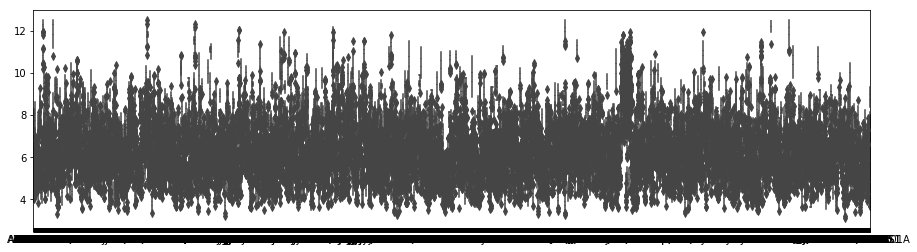

In [207]:
plt.figure(figsize=(15,4))
sns.boxplot(data=X)

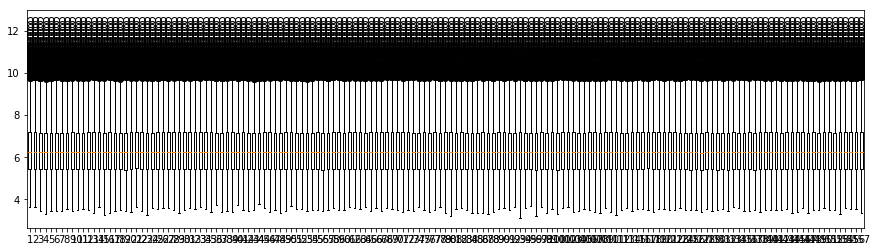

In [208]:
plt.figure(figsize=(15,4))
plt.boxplot(X)
plt.show()

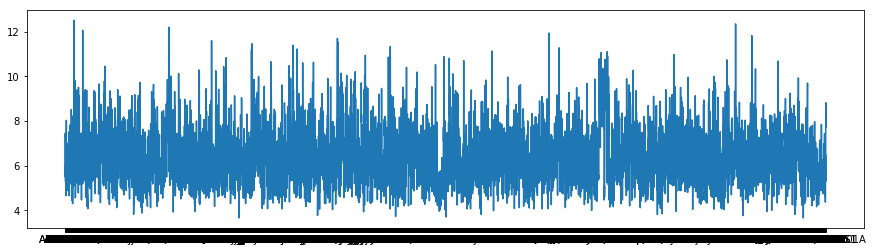

In [209]:
plt.figure(figsize=(15,4))
plt.plot(X.iloc[0])
plt.show()

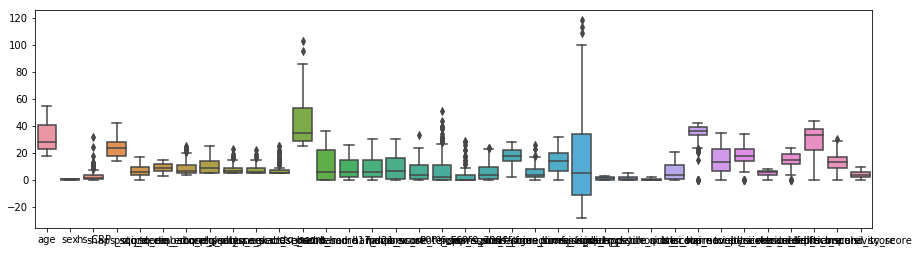

In [529]:
plt.figure(figsize=(15,4))
sns.boxplot(data=Xd)

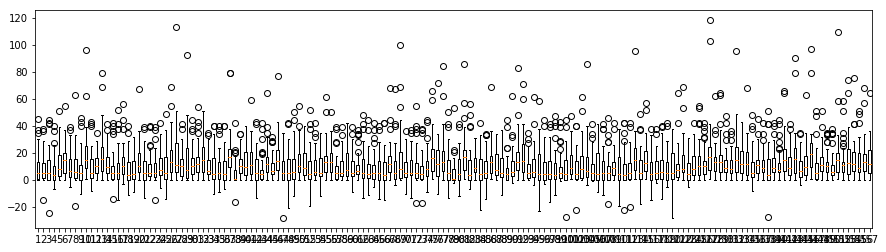

In [530]:
plt.figure(figsize=(15,4))
plt.boxplot(Xd)
plt.show()

### Train - Test split

Since the dataset is not too large, we kept the test size at %20.

In [532]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
Xd_train, Xd_test, yd_train, yd_test = train_test_split(Xd, yd, test_size=0.2, random_state=42)
print("Length of the dataset, X: %d" % len(X_train))
print("Length of the targets, y: %d" % len(y_train))
print("Length of first row of X: %d" % len(X_train.iloc[0]))

Length of the dataset, X: 125
Length of the targets, y: 125
Length of first row of X: 5587


In [124]:
X_train.head()

,AACS,AAK1,AAMDC,AANAT,AARD,AARS2,AARSD1,AASDHPPT,AASS,AATK,...,ZSCAN26,ZSCAN30,ZSCAN4,ZSWIM8,ZSWIM8-AS1,ZWILCH,ZYG11A,ZYX,ZZEF1,ZZZ3
1.59,5.41091,5.38142,7.42114,6.82676,5.3361,5.97844,4.99085,4.33025,4.67144,6.30093,...,5.3549,5.58172,4.59327,4.32413,7.55047,3.77648,6.53708,5.31667,9.04544,7.8442
1.28,5.31147,5.61038,7.70352,6.74962,5.23202,5.96687,4.88277,4.56117,4.91479,6.19321,...,5.34273,5.49633,4.5978,4.50744,7.46635,4.25056,6.49782,5.47147,9.16267,8.08392
1.48,5.39771,5.44697,7.60473,6.85792,5.2622,5.66789,4.97783,4.12217,4.70214,6.26712,...,5.3361,5.49254,4.48022,4.34924,7.40191,4.02647,6.66427,5.37776,8.70963,7.96916
0.47,5.24127,5.5894,7.49207,6.69335,5.15422,5.86223,4.90096,4.44035,4.71467,6.39262,...,5.45624,5.56966,4.45467,4.34349,7.43908,4.21034,6.65607,5.44018,8.85288,7.91867
0.61,5.22449,5.62184,7.79561,6.5209,5.21097,6.01341,4.58554,5.16044,5.24653,6.42666,...,5.11408,5.51659,4.66465,4.24883,7.14956,4.33025,6.55358,5.64288,8.92526,8.0112


In [126]:
y_train[0:5]

[1.0, 1.0, 1.0, 0.0, 0.0]

In [538]:
Xd_train.head()

,age,sex,hs-CRP,shaps_score,psqi_score,ctq_denial_score,ctq_emoabuse_score,ctq_emoneglect_score,ctq_physabuse_score,ctq_physneglect_score,...,qids_psychomotor_score,qids_score,tci_coop_score,tci_harmavoid_score,tci_noveltyseek_score,tci_persistence_score,tci_rewarddep_score,tci_selfdirect_score,tci_selftranscend_score,tci_impulsivity_score
si,,,,,,,,,,,,,,,,,,,,,
AK683,27,1,3.0436,23.946667,7.281046,9.133333,9.226667,10.2,7.973333,7.226667,...,0.344371,6.138158,33.836601,14.490196,17.973856,5.541096,14.712418,29.535948,13.045752,3.938356
AE646,20,1,3.2000,33.000000,13.000000,13.000000,5.000000,6.0,7.000000,7.000000,...,0.000000,16.000000,36.000000,27.000000,21.000000,7.000000,14.000000,20.000000,18.000000,4.000000
AJ537,53,1,3.2000,41.000000,12.000000,5.000000,11.000000,18.0,7.000000,10.000000,...,1.000000,14.000000,28.000000,30.000000,10.000000,3.000000,12.000000,15.000000,4.000000,3.000000
AG245,33,1,2.0000,14.000000,1.000000,14.000000,5.000000,5.0,9.000000,5.000000,...,0.000000,2.000000,33.000000,10.000000,20.000000,6.000000,16.000000,34.000000,11.000000,4.000000
AH639,24,1,4.5000,20.000000,4.000000,14.000000,7.000000,5.0,5.000000,5.000000,...,0.000000,0.000000,41.000000,2.000000,28.000000,4.000000,21.000000,39.000000,22.000000,8.000000


## Feature Selection on Demographic Symptom

### Select K Best
    - ANOVA f-value
    - Mutual information
Chi square is not applicable due to negative values.

In [541]:
dsk10f = SelectKBest(f_classif, k=10)
dsk10f.fit_transform(Xd, yd)
Xd_k10f = Xd.iloc[:,dsk10f.get_support(indices=True)]
Xd_k10f.shape

(157, 10)

In [542]:
Xd_k10f.keys()

Index(['shaps_score', 'madrs_score', 'hamd_hamd17_score', 'hamd_hamd21_score',
       'hama_score', 'poms_score_fatigue', 'poms_score_tmd',
       'qids_sleep_score', 'qids_appetite_score', 'qids_score'],
      dtype='object')

In [543]:
dsk10m = SelectKBest(mutual_info_classif, k=10)
dsk10m.fit_transform(Xd, yd)
Xd_k10m = Xd.iloc[:,dsk10m.get_support(indices=True)]
Xd_k10m.shape

(157, 10)

In [545]:
Xd_k10m.keys()

Index(['shaps_score', 'psqi_score', 'madrs_score', 'hamd_hamd17_score',
       'hamd_hamd21_score', 'hama_score', 'poms_score_depression',
       'poms_score_tmd', 'qids_appetite_score', 'qids_score'],
      dtype='object')

### Select Percentile - %10
    - ANOVA f-value
    - Mutual information
Chi square is not applicable due to negative values.

In [551]:
dsp1f = SelectPercentile(f_classif, percentile=10)
dsp1f.fit_transform(Xd, yd)
Xd_1pf = Xd.iloc[:,dsp1f.get_support(indices=True)]
Xd_1pf.shape

(157, 4)

In [552]:
Xd_1pf.keys()

Index(['madrs_score', 'hamd_hamd17_score', 'hamd_hamd21_score', 'hama_score'], dtype='object')

In [553]:
dsp1m = SelectPercentile(mutual_info_classif, percentile=10)
dsp1m.fit_transform(Xd, yd)
Xd_1pm = Xd.iloc[:,dsp1m.get_support(indices=True)]
Xd_1pm.shape

(157, 4)

In [554]:
Xd_1pm.keys()

Index(['madrs_score', 'hamd_hamd17_score', 'hamd_hamd21_score', 'hama_score'], dtype='object')

In [768]:
Xd_train_1pm, Xd_test_1pm, yd_train_1pm, yd_test_1pm = train_test_split(Xd_1pm, yd, test_size=0.2, random_state=42)
gnb_d1pm = GaussianNB()
gnb_d1pm.fit(Xd_train_1pm, yd_train_1pm)
gnb_p_d1pm = gnb_d1pm.predict(Xd_test_1pm)
print("Gaussian Naive Bayes Classifier report for RFECV: \n\n", classification_report(yd_test_1pm, gnb_p_d1pm))

Gaussian Naive Bayes Classifier report for RFECV: 

               precision    recall  f1-score   support

           0       0.93      0.93      0.93        14
           1       0.94      0.94      0.94        18

   micro avg       0.94      0.94      0.94        32
   macro avg       0.94      0.94      0.94        32
weighted avg       0.94      0.94      0.94        32



### Recursive Feature Elimination with Cross Validation (RFECV)

In [555]:
gnb = GaussianNB()

drfecv = RFECV(
    estimator=svc,
    step=1,
    cv=StratifiedKFold(2),
    scoring="accuracy",
    min_features_to_select=2,
)
drfecv.fit(Xd, yd)

print("Optimal number of features : %d" % drfecv.n_features_)

Optimal number of features : 2


C:\Users\slm\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:665: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
C:\Users\slm\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:437: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review you

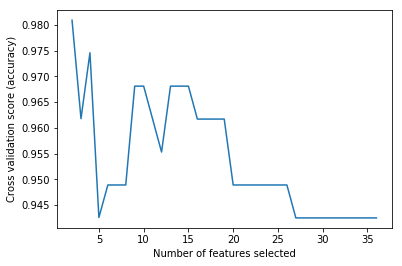

In [556]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(2, len(drfecv.grid_scores_) + 2),
    drfecv.grid_scores_,
)
plt.show()

In [557]:
drfecv.ranking_

array([32, 34,  2,  5,  1,  6,  8, 33, 15, 22, 29, 28,  7,  4,  1,  3, 30,
       10, 13, 23,  9, 16, 11, 35, 18, 21, 20, 17, 12, 24, 25, 26, 14, 31,
       19, 27])

In [558]:
len(drfecv.support_)

36

In [559]:
drfefn = []
for i in range(len(drfecv.support_)):
    if drfecv.support_[i] == True:
        print(Xd.keys().tolist()[i] + " "+ str(i))
        drfefn.append(Xd.keys().tolist()[i])

psqi_score 4
hamd_hamd21_score 14


In [561]:
Xd_rfe = Xd[drfefn]
Xd_rfe.head()

,psqi_score,hamd_hamd21_score
si,,
AA003,5.0,1.0
AA101,5.0,2.0
AA115,5.0,1.0
AA296,5.0,0.0
AA328,12.0,19.0


In [562]:
Xd_train_rfe, Xd_test_rfe, yd_train_rfe, yd_test_rfe = train_test_split(Xd_rfe, yd, test_size=0.2, random_state=42)
gnb_drfe = GaussianNB()
gnb_drfe.fit(Xd_train_rfe, yd_train_rfe)
gnb_p_drfe = gnb_drfe.predict(Xd_test_rfe)
print("Gaussian Naive Bayes Classifier report for RFECV: \n\n", classification_report(yd_test_rfe, gnb_p_drfe))

Gaussian Naive Bayes Classifier report for RFECV: 

               precision    recall  f1-score   support

           0       0.93      0.93      0.93        14
           1       0.94      0.94      0.94        18

   micro avg       0.94      0.94      0.94        32
   macro avg       0.94      0.94      0.94        32
weighted avg       0.94      0.94      0.94        32



## Feature Selection on Gene Expression

### Select K Best
    - Chi square
    - ANOVA f-value
    - Mutual information

In [201]:
sk10 = SelectKBest(chi2, k=10)
sk10.fit_transform(X, y)
X_k10 = X.iloc[:,sk10.get_support(indices=True)]
X_p.shape

(157, 10)

In [202]:
X_k10.keys()

Index(['CD83', 'DPEP3', 'FAM129B', 'HMGN2P46', 'MDGA1', 'NKX1-1', 'RARS2',
       'TNC', 'UBD', 'ZDHHC20'],
      dtype='object')

In [203]:
sk10f = SelectKBest(f_classif, k=10)
sk10f.fit_transform(X, y)
X_k10f = X.iloc[:,sk10f.get_support(indices=True)]
X_k10f.shape

(157, 10)

In [204]:
X_k10f.keys()

Index(['ARFGAP1', 'BCL2L12', 'CBL', 'FAM138A', 'IRF2BPL', 'KANTR', 'MDGA1',
       'NPFF', 'UBD', 'ZDHHC20'],
      dtype='object')

In [205]:
sk10m = SelectKBest(mutual_info_classif, k=10)
sk10m.fit_transform(X, y)
X_k10m = X.iloc[:,sk10m.get_support(indices=True)]
X_k10m.shape

(157, 10)

In [206]:
X_k10m.keys()

Index(['AASS', 'ARPC4', 'BAZ2A', 'FUNDC1', 'MKNK1-AS1', 'RNASEH1-AS1', 'RPL15',
       'SNX18', 'SRSF7', 'ZMYM6NB'],
      dtype='object')

In [431]:
X_train_k10, X_test_k10, y_train_k10, y_test_k10 = train_test_split(X_k10, y, test_size=0.2, random_state=42)
X_train_k10f, X_test_k10f, y_train_k10f, y_test_k10f = train_test_split(X_k10f, y, test_size=0.2, random_state=42)
X_train_k10m, X_test_k10m, y_train_k10m, y_test_k10m = train_test_split(X_k10m, y, test_size=0.2, random_state=42)

gnb1,gnb2,gnb3 = GaussianNB(),GaussianNB(),GaussianNB()
gnb1.fit(X_train_k10, y_train_k10)
gnb2.fit(X_train_k10f, y_train_k10f)
gnb3.fit(X_train_k10m, y_train_k10m)
gnb_k10 = gnb1.predict(X_test_k10)
print("Gaussian Naive Bayes Classifier report for 10-best with chi square: \n\n", classification_report(y_test_k10, gnb_k10))
gnb_k10f = gnb2.predict(X_test_k10f)
print("Gaussian Naive Bayes Classifier report for 10-best with f-value: \n\n", classification_report(y_test_k10f, gnb_k10f))
gnb_k10m = gnb3.predict(X_test_k10m)
print("Gaussian Naive Bayes Classifier report for 10-best with mutual info: \n\n", classification_report(y_test_k10m, gnb_k10m))

Gaussian Naive Bayes Classifier report for 10-best with chi square: 

               precision    recall  f1-score   support

         0.0       0.70      0.50      0.58        14
         1.0       0.68      0.83      0.75        18

   micro avg       0.69      0.69      0.69        32
   macro avg       0.69      0.67      0.67        32
weighted avg       0.69      0.69      0.68        32

Gaussian Naive Bayes Classifier report for 10-best with f-value: 

               precision    recall  f1-score   support

         0.0       0.75      0.43      0.55        14
         1.0       0.67      0.89      0.76        18

   micro avg       0.69      0.69      0.69        32
   macro avg       0.71      0.66      0.65        32
weighted avg       0.70      0.69      0.67        32

Gaussian Naive Bayes Classifier report for 10-best with mutual info: 

               precision    recall  f1-score   support

         0.0       0.53      0.57      0.55        14
         1.0       0.65   

### Select Percentile - %1
    - Chi square
    - ANOVA f-value
    - Mutual information

In [216]:
sp1 = SelectPercentile(chi2, percentile=1)
sp1.fit_transform(X, y)
X_1p = X.iloc[:,sp1.get_support(indices=True)]
X_1p.shape

(157, 56)

In [217]:
X_1p.keys()

Index(['ABCE1', 'AHCTF1P1', 'AHSG', 'AP4B1-AS1', 'BIRC5', 'C1orf35', 'CD83',
       'CDC14B', 'CDC20', 'CHMP1B2P', 'CHP1', 'CHSY3', 'DDHD2', 'DDX26B-AS1',
       'DDX58', 'DPEP3', 'EHF', 'ELK4', 'FAM129B', 'FLJ31356', 'FOXRED2',
       'GSC', 'HMGN2P46', 'HNRNPA1P10', 'ICOS', 'IFI16', 'LINC01001', 'LUC7L2',
       'MCTS2P', 'MDGA1', 'METTL4', 'MITF', 'MRPS26', 'MYO1A', 'NAA20',
       'NKX1-1', 'NR1H2', 'OIP5', 'PAPL', 'POGZ', 'PPP2R5C', 'PTP4A2', 'RARS2',
       'SS18L2', 'SUMO3', 'TAF1D', 'TNC', 'TOMM34', 'UBD', 'WDR76', 'ZDHHC20',
       'ZFP36L2', 'ZMYM6NB', 'ZNF225', 'ZNF518B', 'ZNF549'],
      dtype='object')

In [191]:
sp1f = SelectPercentile(f_classif, percentile=1)
sp1f.fit_transform(X, y)
X_1pf = X.iloc[:,sp1f.get_support(indices=True)]
X_1pf.shape

(157, 56)

In [192]:
X_1pf.keys()

Index(['ABCE1', 'AP1G2', 'ARFGAP1', 'ATXN7L2', 'BCL2L12', 'C16orf74',
       'C1orf35', 'CBL', 'CCAR2', 'CD83', 'CDC20', 'CDK5RAP2', 'CSPG4',
       'DPEP3', 'DYNLRB1', 'EIF2D', 'ELP3', 'EXOSC2', 'FAM129B', 'FAM138A',
       'FAM193A', 'HMGN2P46', 'HNRNPUL2', 'ICOS', 'IRF2BPL', 'ISX', 'KANTR',
       'KPNA2', 'LEUTX', 'LRRC37BP1', 'MCM3AP-AS1', 'MDGA1', 'METAP1D',
       'NDUFB1', 'NGRN', 'NPFF', 'PANX1', 'POGZ', 'PRPF31', 'RARS2', 'RCSD1',
       'SETDB2', 'SRSF5', 'SS18L2', 'STX16-NPEPL1', 'SUPT7L', 'TADA3',
       'TOMM34', 'TRPC5', 'TSC2', 'TSR3', 'UBD', 'ZDHHC20', 'ZFP36L2',
       'ZMYM6NB', 'ZNF658'],
      dtype='object')

In [193]:
sp1m = SelectPercentile(mutual_info_classif, percentile=1)
sp1m.fit_transform(X, y)
X_1pm = X.iloc[:,sp1m.get_support(indices=True)]
X_1pm.shape

(157, 56)

In [194]:
X_1pm.keys()

Index(['AASS', 'ANAPC4', 'ARPC4', 'BAZ2A', 'C9orf116', 'CASP10', 'CCAR2',
       'COPB2', 'COPS6', 'DNAJC11', 'EIF3A', 'FCGBP', 'FOXN3-AS1', 'FUNDC1',
       'GSC', 'HADH', 'HNRNPA1P10', 'HSPE1', 'IREB2', 'KBTBD3', 'KDM1B',
       'LEUTX', 'LIMK2', '8-Mar', 'MIIP', 'MKNK1-AS1', 'MPO', 'MRPS31',
       'N4BP2L1', 'NAB2', 'NUDT6', 'PCYT1A', 'PTCH1', 'RCSD1', 'RNASEH1-AS1',
       'RNASEH2B-AS1', 'RPL15', 'RRP9', 'SEC61A2', 'SEPW1', 'SLC35A5', 'SNX18',
       'SRSF7', 'STYXL1', 'SUPT7L', 'TAB3', 'TBCA', 'TRIM39', 'TYRP1', 'UBL4B',
       'UBR4', 'VPS18', 'WSCD1', 'ZBTB11-AS1', 'ZFP91-CNTF', 'ZMYM6NB'],
      dtype='object')

In [432]:
X_train_1p, X_test_1p, y_train_1p, y_test_1p = train_test_split(X_1p, y, test_size=0.2, random_state=42)
X_train_1pf, X_test_1pf, y_train_1pf, y_test_1pf = train_test_split(X_1pf, y, test_size=0.2, random_state=42)
X_train_1pm, X_test_1pm, y_train_1pm, y_test_1pm = train_test_split(X_1pm, y, test_size=0.2, random_state=42)

gnb4,gnb5,gnb6 = GaussianNB(),GaussianNB(),GaussianNB()
gnb4.fit(X_train_1p, y_train_1p)
gnb5.fit(X_train_1pf, y_train_1pf)
gnb6.fit(X_train_1pm, y_train_1pm)
gnb_1p = gnb4.predict(X_test_1p)
print("Gaussian Naive Bayes Classifier report for best %1 with chi square: \n\n", classification_report(y_test_1p, gnb_1p))
gnb_1pf = gnb5.predict(X_test_1pf)
print("Gaussian Naive Bayes Classifier report for best %1 with f-value: \n\n", classification_report(y_test_1pf, gnb_1pf))
gnb_1pm = gnb6.predict(X_test_1pm)
print("Gaussian Naive Bayes Classifier report for best %1 with mutual info: \n\n", classification_report(y_test_1pm, gnb_1pm))

Gaussian Naive Bayes Classifier report for best %1 with chi square: 

               precision    recall  f1-score   support

         0.0       0.60      0.43      0.50        14
         1.0       0.64      0.78      0.70        18

   micro avg       0.62      0.62      0.62        32
   macro avg       0.62      0.60      0.60        32
weighted avg       0.62      0.62      0.61        32

Gaussian Naive Bayes Classifier report for best %1 with f-value: 

               precision    recall  f1-score   support

         0.0       0.67      0.43      0.52        14
         1.0       0.65      0.83      0.73        18

   micro avg       0.66      0.66      0.66        32
   macro avg       0.66      0.63      0.63        32
weighted avg       0.66      0.66      0.64        32

Gaussian Naive Bayes Classifier report for best %1 with mutual info: 

               precision    recall  f1-score   support

         0.0       0.38      0.36      0.37        14
         1.0       0.53   

Select Percentile %0.1

In [221]:
sp01f = SelectPercentile(f_classif, percentile=0.1)
sp01f.fit_transform(X, y)
X_01pf = X.iloc[:,sp01f.get_support(indices=True)]
X_01pf.shape

(157, 6)

In [222]:
X_01pf.keys()

Index(['ARFGAP1', 'FAM138A', 'IRF2BPL', 'MDGA1', 'NPFF', 'ZDHHC20'], dtype='object')

In [433]:
X_train_01pf, X_test_01pf, y_train_01pf, y_test_01pf = train_test_split(X_01pf, y, test_size=0.2, random_state=42)
gnb7 = GaussianNB()
gnb7.fit(X_train_01pf, y_train_01pf)
gnb_p_01pf = gnb7.predict(X_test_01pf)
print("Gaussian Naive Bayes Classifier report for best %0.1 with f-value: \n\n", classification_report(y_test_01pf, gnb_p_01pf))

Gaussian Naive Bayes Classifier report for best %0.1 with f-value: 

               precision    recall  f1-score   support

         0.0       0.70      0.50      0.58        14
         1.0       0.68      0.83      0.75        18

   micro avg       0.69      0.69      0.69        32
   macro avg       0.69      0.67      0.67        32
weighted avg       0.69      0.69      0.68        32



### False Positive Rate
    - Chi square
    - ANOVA f-value
Mutual information is not included for this method due to NoneType values

In [283]:
fpr = SelectFpr(chi2, alpha=0.79)
fpr.fit_transform(X, y)
fprf = SelectFpr(f_classif, alpha=0.001)
fprf.fit_transform(X, y)
#fprm = SelectFpr(mutual_info_classif, alpha=1)
#fprm.fit_transform(X, y)
X_fpr = X.iloc[:,fpr.get_support(indices=True)]
X_fprf = X.iloc[:,fprf.get_support(indices=True)]
#X_fprm = X.iloc[:,fprm.get_support(indices=True)]

In [284]:
X_fpr.keys()

Index(['ABCE1', 'AHCTF1P1', 'AHSG', 'AP4B1-AS1', 'BIRC5', 'C1orf35', 'CD83',
       'CDC14B', 'CDC20', 'DDHD2', 'DDX26B-AS1', 'DPEP3', 'EHF', 'FAM129B',
       'FLJ31356', 'FOXRED2', 'GSC', 'HMGN2P46', 'HNRNPA1P10', 'ICOS', 'IFI16',
       'LINC01001', 'LUC7L2', 'MDGA1', 'METTL4', 'MRPS26', 'NAA20', 'NKX1-1',
       'NR1H2', 'OIP5', 'PAPL', 'POGZ', 'RARS2', 'SS18L2', 'SUMO3', 'TNC',
       'UBD', 'WDR76', 'ZDHHC20', 'ZFP36L2', 'ZMYM6NB', 'ZNF225', 'ZNF518B',
       'ZNF549'],
      dtype='object')

In [285]:
X_fprf.keys()

Index(['ABCE1', 'ARFGAP1', 'ATXN7L2', 'BCL2L12', 'C16orf74', 'C1orf35', 'CBL',
       'CCAR2', 'CD83', 'CDK5RAP2', 'CSPG4', 'DPEP3', 'DYNLRB1', 'EIF2D',
       'ELP3', 'FAM138A', 'FAM193A', 'HMGN2P46', 'HNRNPUL2', 'ICOS', 'IRF2BPL',
       'ISX', 'KANTR', 'LEUTX', 'MCM3AP-AS1', 'MDGA1', 'NDUFB1', 'NGRN',
       'NPFF', 'PANX1', 'POGZ', 'RARS2', 'RCSD1', 'SETDB2', 'SRSF5', 'SS18L2',
       'STX16-NPEPL1', 'SUPT7L', 'TADA3', 'TOMM34', 'TRPC5', 'TSC2', 'TSR3',
       'UBD', 'ZDHHC20', 'ZFP36L2', 'ZMYM6NB', 'ZNF658'],
      dtype='object')

In [765]:
len(X_fprf.keys())

48

In [434]:
X_train_fpr, X_test_fpr, y_train_fpr, y_test_fpr = train_test_split(X_fpr, y, test_size=0.2, random_state=42)
X_train_fprf, X_test_fprf, y_train_fprf, y_test_fprf = train_test_split(X_fprf, y, test_size=0.2, random_state=42)

gnb_fpr,gnb_fprf = GaussianNB(),GaussianNB()
gnb_fpr.fit(X_train_fpr, y_train_fpr)
gnb_fprf.fit(X_train_fprf, y_train_fprf)
gnb_p_fpr = gnb_fpr.predict(X_test_fpr)
print("Gaussian Naive Bayes Classifier report for FPR chi square: \n\n", classification_report(y_test_fpr, gnb_p_fpr))
gnb_p_fprf = gnb_fprf.predict(X_test_fprf)
print("Gaussian Naive Bayes Classifier report for FPR f-value: \n\n", classification_report(y_test_fprf, gnb_p_fprf))

Gaussian Naive Bayes Classifier report for FPR chi square: 

               precision    recall  f1-score   support

         0.0       0.60      0.43      0.50        14
         1.0       0.64      0.78      0.70        18

   micro avg       0.62      0.62      0.62        32
   macro avg       0.62      0.60      0.60        32
weighted avg       0.62      0.62      0.61        32

Gaussian Naive Bayes Classifier report for FPR f-value: 

               precision    recall  f1-score   support

         0.0       0.67      0.43      0.52        14
         1.0       0.65      0.83      0.73        18

   micro avg       0.66      0.66      0.66        32
   macro avg       0.66      0.63      0.63        32
weighted avg       0.66      0.66      0.64        32



### False Discovery Rate
    - ANOVA f-value
Chi square is excluded since there is no significance found in false discoveries with this method.

Mutual information is not included for this method due to NoneType values

In [332]:
fdr = SelectFdr(chi2, alpha=0.99)
fdr.fit_transform(X, y)
fdrf = SelectFdr(f_classif, alpha=0.11)
fdrf.fit_transform(X, y)
#fdrm = SelectFdr(mutual_info_classif, alpha=1)
#fdrm.fit_transform(X, y)
X_fdr = X.iloc[:,fdr.get_support(indices=True)]
X_fdrf = X.iloc[:,fdrf.get_support(indices=True)]
#X_fdrm = X.iloc[:,fdrm.get_support(indices=True)]

C:\Users\slm\Anaconda3\lib\site-packages\sklearn\feature_selection\base.py:80: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  UserWarning)


In [314]:
X_fdr.keys()

Index([], dtype='object')

In [333]:
X_fdrf.keys()

Index(['ABCE1', 'ARFGAP1', 'ATXN7L2', 'BCL2L12', 'C16orf74', 'CBL', 'CCAR2',
       'CD83', 'CDK5RAP2', 'CSPG4', 'DPEP3', 'DYNLRB1', 'EIF2D', 'FAM138A',
       'FAM193A', 'HMGN2P46', 'HNRNPUL2', 'ICOS', 'IRF2BPL', 'ISX', 'KANTR',
       'MDGA1', 'NDUFB1', 'NGRN', 'NPFF', 'PANX1', 'POGZ', 'RARS2', 'RCSD1',
       'SETDB2', 'SRSF5', 'SS18L2', 'STX16-NPEPL1', 'SUPT7L', 'TADA3',
       'TOMM34', 'TRPC5', 'TSC2', 'TSR3', 'UBD', 'ZDHHC20', 'ZFP36L2',
       'ZMYM6NB', 'ZNF658'],
      dtype='object')

In [766]:
len(X_fdrf.keys())

44

In [435]:
X_train_fdrf, X_test_fdrf, y_train_fdrf, y_test_fdrf = train_test_split(X_fdrf, y, test_size=0.2, random_state=42)
gnb_fdrf = GaussianNB()
gnb_fdrf.fit(X_train_fdrf, y_train_fdrf)
gnb_p_fdrf = gnb_fdrf.predict(X_test_fdrf)
print("Gaussian Naive Bayes Classifier report for best FDR f-value: \n\n", classification_report(y_test_fdrf, gnb_p_fdrf))

Gaussian Naive Bayes Classifier report for best FDR f-value: 

               precision    recall  f1-score   support

         0.0       0.75      0.43      0.55        14
         1.0       0.67      0.89      0.76        18

   micro avg       0.69      0.69      0.69        32
   macro avg       0.71      0.66      0.65        32
weighted avg       0.70      0.69      0.67        32



### Family Wise Error
    - ANOVA f-value
Chi square is excluded since there is no significance found in false discoveries with this method.

Mutual information is not included for this method due to NoneType values

In [350]:
fwe = SelectFwe(chi2, alpha=0.99)
fwe.fit_transform(X, y)
fwef = SelectFwe(f_classif, alpha=0.99)
fwef.fit_transform(X, y)
#fwem = SelectFwe(mutual_info_classif, alpha=1)
#fwem.fit_transform(X, y)
X_fwe = X.iloc[:,fwe.get_support(indices=True)]
X_fwef = X.iloc[:,fwef.get_support(indices=True)]
#X_fwem = X.iloc[:,fwem.get_support(indices=True)]

C:\Users\slm\Anaconda3\lib\site-packages\sklearn\feature_selection\base.py:80: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  UserWarning)


In [344]:
X_fwe.keys()

Index([], dtype='object')

In [351]:
X_fwef.keys()

Index(['ARFGAP1', 'MDGA1', 'NPFF', 'ZDHHC20'], dtype='object')

In [436]:
X_train_fwef, X_test_fwef, y_train_fwef, y_test_fwef = train_test_split(X_fwef, y, test_size=0.2, random_state=42)
gnb_fwef = GaussianNB()
gnb_fwef.fit(X_train_fwef, y_train_fwef)
gnb_p_fwef = gnb_fwef.predict(X_test_fwef)
print("Gaussian Naive Bayes Classifier report for best FWE f-value: \n\n", classification_report(y_test_fwef, gnb_p_fwef))

Gaussian Naive Bayes Classifier report for best FWE f-value: 

               precision    recall  f1-score   support

         0.0       0.60      0.43      0.50        14
         1.0       0.64      0.78      0.70        18

   micro avg       0.62      0.62      0.62        32
   macro avg       0.62      0.60      0.60        32
weighted avg       0.62      0.62      0.61        32



### Recursive Feature Elimination with Cross Validation (RFECV)

In [196]:
gnb = GaussianNB()

rfecv = RFECV(
    estimator=svc,
    step=1,
    cv=StratifiedKFold(2),
    scoring="accuracy",
    min_features_to_select=2,
)
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

C:\Users\slm\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:665: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
C:\Users\slm\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:437: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review you

Optimal number of features : 4


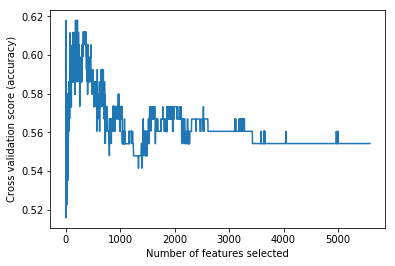

In [197]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(2, len(rfecv.grid_scores_) + 2),
    rfecv.grid_scores_,
)
plt.show()

In [198]:
rfecv.ranking_

array([5251,  834, 5443, ..., 1538, 3434, 4062])

In [199]:
len(rfecv.support_)

5587

In [200]:
rfegn = []
for i in range(len(rfecv.support_)):
    if rfecv.support_[i] == True:
        print(X.keys().tolist()[i] + " "+ str(i))
        rfegn.append(X.keys().tolist()[i])

CDC14B 771
ELP3 1445
MICU1 2664
TUSC3 5034


In [166]:
X_rfe = X[rfegn]
X_rfe.head()

,CDC14B,ELP3,MICU1,TUSC3
0,6.14148,6.02133,5.13999,4.69555
0.1,5.92282,6.2366,4.94526,4.75867
0.2,5.78886,5.8695,5.21779,4.79789
0.3,5.20258,5.88696,5.69822,4.96119
1,6.3265,6.05481,5.40493,4.6487


In [167]:
X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe = train_test_split(X_rfe, y, test_size=0.2, random_state=42)
print("Length of the dataset, X: %d" % len(X_train_rfe))
print("Length of the targets, y: %d" % len(y_train_rfe))

Length of the dataset, X: 125
Length of the targets, y: 125


In [437]:
gnb_rfe = GaussianNB()
gnb_rfe.fit(X_train_rfe, y_train_rfe)
gnb_p_rfe = gnb_rfe.predict(X_test_rfe)
print("Gaussian Naive Bayes Classifier report for RFECV: \n\n", classification_report(y_test_rfe, gnb_p_rfe))

Gaussian Naive Bayes Classifier report for RFECV: 

               precision    recall  f1-score   support

         0.0       0.60      0.64      0.62        14
         1.0       0.71      0.67      0.69        18

   micro avg       0.66      0.66      0.66        32
   macro avg       0.65      0.65      0.65        32
weighted avg       0.66      0.66      0.66        32



### L-1 Based Feature Selection with SelectFromModel

Threshold parameter selects features with greater "mean" than the given value. When set to 0.1, results with 5 features.

In [263]:
sfm = SelectFromModel(estimator=LinearSVC(C=0.1, penalty="l1", dual=False),threshold=0.1).fit(X, y)
X_sfm = X.iloc[:,sfm.get_support(indices=True)]
X_sfm.shape

C:\Users\slm\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


(157, 5)

In [260]:
X_sfm

Index(['GSC', 'HMGN2P46', 'MDGA1', 'PANX1', 'UBD'], dtype='object')

In [438]:
X_train_sfm, X_test_sfm, y_train_sfm, y_test_sfm = train_test_split(X_sfm, y, test_size=0.2, random_state=42)
gnb8 = GaussianNB()
gnb8.fit(X_train_sfm, y_train_sfm)
gnb_p_sfm = gnb8.predict(X_test_sfm)
print("Gaussian Naive Bayes Classifier report for SFM L1: \n\n", classification_report(y_test_sfm, gnb_p_sfm))

Gaussian Naive Bayes Classifier report for SFM L1: 

               precision    recall  f1-score   support

         0.0       0.64      0.50      0.56        14
         1.0       0.67      0.78      0.72        18

   micro avg       0.66      0.66      0.66        32
   macro avg       0.65      0.64      0.64        32
weighted avg       0.65      0.66      0.65        32



### Random Tree Based Feature Selection with SelectFromModel

Threshold parameter selects features with greater "mean" than the given value. When set to 0.015, results with 6 features.

In [353]:
sfmt = SelectFromModel(estimator=RandomForestClassifier(),threshold=0.015).fit(X, y)
X_sfmt = X.iloc[:,sfmt.get_support(indices=True)]
X_sfmt.shape

C:\Users\slm\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\slm\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:487: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_store_unique_indices = np.zeros(y.shape, dtype=np.int)
C:\Users\slm\Anaconda3\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To sil

(157, 8)

In [354]:
X_sfmt.keys()

Index(['C6orf118', 'ELK4', 'FAM109A', 'FOXL1', 'N4BP2', 'UBE2Q1', 'ZDHHC20',
       'ZFYVE27'],
      dtype='object')

In [439]:
X_train_sfmt, X_test_sfmt, y_train_sfmt, y_test_sfmt = train_test_split(X_sfmt, y, test_size=0.2, random_state=42)
gnb_sfmt = GaussianNB()
gnb_sfmt.fit(X_train_sfmt, y_train_sfmt)
gnb_p_sfmt = gnb_sfmt.predict(X_test_sfmt)
print("Gaussian Naive Bayes Classifier report for SFM Tree: \n\n", classification_report(y_test_sfmt, gnb_p_sfmt))

Gaussian Naive Bayes Classifier report for SFM Tree: 

               precision    recall  f1-score   support

         0.0       0.67      0.57      0.62        14
         1.0       0.70      0.78      0.74        18

   micro avg       0.69      0.69      0.69        32
   macro avg       0.68      0.67      0.68        32
weighted avg       0.69      0.69      0.68        32



### Finding most common genes from different feature selection methods

In [580]:
keys = [X_01pf, X_1p, X_1pf, X_1pm, X_fdr, X_fdrf, X_fpr, X_fprf, X_fwe, X_fwef, X_k10, X_k10f, X_k10m, X_rfe, X_sfm, X_sfmt]
nkeys = []
for i in keys:
    for j in i.keys().tolist():
        nkeys.append(j)
from collections import Counter
c = Counter(nkeys)
gns = np.asarray(c.most_common(10)).T[0].tolist()
print(gns)

['MDGA1', 'ZDHHC20', 'UBD', 'HMGN2P46', 'ZMYM6NB', 'ARFGAP1', 'NPFF', 'CD83', 'DPEP3', 'RARS2']


In [761]:
c.most_common(15)

[('MDGA1', 10),
 ('ZDHHC20', 10),
 ('UBD', 8),
 ('HMGN2P46', 7),
 ('ZMYM6NB', 7),
 ('ARFGAP1', 6),
 ('NPFF', 6),
 ('CD83', 6),
 ('DPEP3', 6),
 ('RARS2', 6),
 ('FAM138A', 5),
 ('IRF2BPL', 5),
 ('ABCE1', 5),
 ('ICOS', 5),
 ('POGZ', 5)]

In [582]:
Xn = X[gns]
Xn.head()

,MDGA1,ZDHHC20,UBD,HMGN2P46,ZMYM6NB,ARFGAP1,NPFF,CD83,DPEP3,RARS2
AA003,6.93689,5.46878,10.3297,7.18671,6.57007,7.96652,6.63618,5.72517,6.7784,5.29601
AA101,6.85034,5.58767,10.4978,7.23615,6.40964,7.81677,6.55868,5.51419,6.78086,5.1249
AA115,6.80861,5.84074,10.5517,6.89765,6.41542,7.90836,6.79757,5.50925,6.90754,5.09822
AA296,6.56737,5.78972,10.7572,6.97251,6.29413,8.10685,6.56952,5.4127,6.37762,5.34857
AA328,7.03226,5.78293,10.9429,6.90454,6.55422,7.86732,6.56504,5.75105,6.6797,5.17789


In [758]:
Xn_train, Xn_test, yn_train, yn_test = train_test_split(Xn, y, test_size=0.2, random_state=42)
ngnb = GaussianNB()
ngnb.fit(Xn_train, y_train)
ngnb_p = ngnb.predict(Xn_test)
print("Gaussian Naive Bayes Classifier report for selected genes: \n\n", classification_report(yn_test, ngnb_p))

Gaussian Naive Bayes Classifier report for selected genes: 

               precision    recall  f1-score   support

         0.0       0.80      0.57      0.67        14
         1.0       0.73      0.89      0.80        18

   micro avg       0.75      0.75      0.75        32
   macro avg       0.76      0.73      0.73        32
weighted avg       0.76      0.75      0.74        32



## Model Selection

### Decision Tree

In [767]:
clf = DecisionTreeClassifier(random_state=0)
cross_val_score(clf, X_train, y_train, cv=10)

C:\Users\slm\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:665: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
C:\Users\slm\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:437: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review you

array([0.38461538, 0.61538462, 0.69230769, 0.53846154, 0.69230769,
       0.66666667, 0.58333333, 0.66666667, 0.5       , 0.75      ])

In [587]:
nclf = DecisionTreeClassifier(random_state=0)
cross_val_score(nclf, Xn_train, yn_train, cv=10)

C:\Users\slm\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:665: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
C:\Users\slm\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:437: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review you

array([0.53846154, 0.61538462, 0.61538462, 0.46153846, 0.61538462,
       0.33333333, 0.58333333, 0.66666667, 0.66666667, 0.5       ])

### Gaussian Naive Bayes

In [429]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb_p = gnb.predict(X_test)
print("Gaussian Naive Bayes Classifier report: \n\n", classification_report(y_test, gnb_p))

Gaussian Naive Bayes Classifier report: 

               precision    recall  f1-score   support

         0.0       0.50      0.43      0.46        14
         1.0       0.60      0.67      0.63        18

   micro avg       0.56      0.56      0.56        32
   macro avg       0.55      0.55      0.55        32
weighted avg       0.56      0.56      0.56        32



In [744]:
ngnb = GaussianNB()
ngnb.fit(Xn_train, yn_train)
ngnb_p = ngnb.predict(Xn_test)
print("Gaussian Naive Bayes Classifier report for selected genes: \n\n", classification_report(yn_test, ngnb_p))

Gaussian Naive Bayes Classifier report for selected genes: 

               precision    recall  f1-score   support

         0.0       0.80      0.57      0.67        14
         1.0       0.73      0.89      0.80        18

   micro avg       0.75      0.75      0.75        32
   macro avg       0.76      0.73      0.73        32
weighted avg       0.76      0.75      0.74        32



### K-Nearest Neighbor

In [745]:
knn = KNeighborsClassifier(13)
knn.fit(X_train, y_train)
knn_p = knn.predict(X_test)
print("K-Nearest Neighbor Classifier report: \n\n", classification_report(y_test, knn_p))

K-Nearest Neighbor Classifier report: 

               precision    recall  f1-score   support

         0.0       0.53      0.57      0.55        14
         1.0       0.65      0.61      0.63        18

   micro avg       0.59      0.59      0.59        32
   macro avg       0.59      0.59      0.59        32
weighted avg       0.60      0.59      0.59        32



C:\Users\slm\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:907: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._y = np.empty(y.shape, dtype=np.int)


In [746]:
nknn = KNeighborsClassifier(6)
nknn.fit(Xn_train, yn_train)
nknn_p = nknn.predict(Xn_test)
print("K-Nearest Neighbor Classifier report for selected genes: \n\n", classification_report(yn_test, nknn_p))

K-Nearest Neighbor Classifier report for selected genes: 

               precision    recall  f1-score   support

         0.0       0.67      0.86      0.75        14
         1.0       0.86      0.67      0.75        18

   micro avg       0.75      0.75      0.75        32
   macro avg       0.76      0.76      0.75        32
weighted avg       0.77      0.75      0.75        32



C:\Users\slm\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:907: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._y = np.empty(y.shape, dtype=np.int)


### Linear SVC

In [747]:
lsvc = LinearSVC(C=0.1, penalty="l1", dual=False)
lsvc.fit(X_train, y_train)
lsvc_p = lsvc.predict(X_test)
print("Linear SVC report: \n\n", classification_report(y_test, lsvc_p))

Linear SVC report: 

               precision    recall  f1-score   support

         0.0       0.42      0.57      0.48        14
         1.0       0.54      0.39      0.45        18

   micro avg       0.47      0.47      0.47        32
   macro avg       0.48      0.48      0.47        32
weighted avg       0.49      0.47      0.47        32



C:\Users\slm\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\slm\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:283: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)


In [748]:
nlsvc = LinearSVC(C=0.25, penalty="l1", dual=False)
nlsvc.fit(Xn_train, yn_train)
nlsvc_p = nlsvc.predict(Xn_test)
print("Linear SVC report for selected genes: \n\n", classification_report(yn_test, nlsvc_p))

Linear SVC report for selected genes: 

               precision    recall  f1-score   support

         0.0       0.73      0.57      0.64        14
         1.0       0.71      0.83      0.77        18

   micro avg       0.72      0.72      0.72        32
   macro avg       0.72      0.70      0.70        32
weighted avg       0.72      0.72      0.71        32



C:\Users\slm\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\slm\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:283: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)


### RBF kernel SVC

In [749]:
rsvc = SVC(gamma=0.15, C=1)
rsvc.fit(X_train, y_train)
rsvc_p = rsvc.predict(X_test)
print("RBF kernel SVC report: \n\n", classification_report(y_test, rsvc_p))

RBF kernel SVC report: 

               precision    recall  f1-score   support

         0.0       0.44      1.00      0.61        14
         1.0       0.00      0.00      0.00        18

   micro avg       0.44      0.44      0.44        32
   macro avg       0.22      0.50      0.30        32
weighted avg       0.19      0.44      0.27        32



C:\Users\slm\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\slm\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\slm\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [750]:
nrsvc = SVC(gamma=8.2, C=1)
nrsvc.fit(Xn_train, yn_train)
nrsvc_p = nrsvc.predict(Xn_test)
print("RBF kernel SVC report for selected genes: \n\n", classification_report(yn_test, nrsvc_p))

RBF kernel SVC report for selected genes: 

               precision    recall  f1-score   support

         0.0       0.83      0.71      0.77        14
         1.0       0.80      0.89      0.84        18

   micro avg       0.81      0.81      0.81        32
   macro avg       0.82      0.80      0.81        32
weighted avg       0.81      0.81      0.81        32



### Simple Dense NN

In [678]:
nn = Sequential()

nn.add(Dense(16, activation = 'relu', input_dim=10))
nn.add(Dense(8, activation = 'relu'))
nn.add(Dense(1, activation = 'sigmoid'))
nn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
                   
nn.fit(Xn_train, yn_train, batch_size = 10, epochs = 1000)

yn_pred = nn.predict(Xn_test)
yn_pred = (yn_pred > 0.5)
print ("Simple DNN report for selected genes:\n\n",classification_report(yn_test, yn_pred))

Epoch 1/1000
125/125 [==============================] - 0s 2ms/sample - loss: 0.7399 - acc: 0.5120
Epoch 2/1000
125/125 [==============================] - 0s 127us/sample - loss: 0.6983 - acc: 0.4800
Epoch 3/1000
125/125 [==============================] - 0s 128us/sample - loss: 0.6827 - acc: 0.5520
Epoch 4/1000
125/125 [==============================] - 0s 168us/sample - loss: 0.6905 - acc: 0.5200
Epoch 5/1000
125/125 [==============================] - 0s 144us/sample - loss: 0.6928 - acc: 0.4880
Epoch 6/1000
125/125 [==============================] - 0s 165us/sample - loss: 0.6858 - acc: 0.5360
Epoch 7/1000
125/125 [==============================] - 0s 135us/sample - loss: 0.6733 - acc: 0.6160
Epoch 8/1000
125/125 [==============================] - 0s 151us/sample - loss: 0.6823 - acc: 0.5520
Epoch 9/1000
125/125 [==============================] - 0s 167us/sample - loss: 0.6706 - acc: 0.6320
Epoch 10/1000
125/125 [==============================] - 0s 144us/sample - loss: 0.6797 - acc

In [683]:
nn = Sequential()

nn.add(Dense(16, activation = 'relu', input_dim=10))
nn.add(Dense(8, activation = 'relu'))
nn.add(Dense(4, activation = 'relu'))
nn.add(Dense(1, activation = 'sigmoid'))
nn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
                   
nn.fit(Xn_train, yn_train, batch_size = 10, epochs = 1000, verbose=0)

yn_pred = nn.predict(Xn_test)
yn_pred = (yn_pred > 0.5)
print ("Simple DNN report for selected genes:\n\n",classification_report(yn_test, yn_pred))

Simple DNN report for selected genes:

               precision    recall  f1-score   support

         0.0       0.69      0.79      0.73        14
         1.0       0.81      0.72      0.76        18

   micro avg       0.75      0.75      0.75        32
   macro avg       0.75      0.75      0.75        32
weighted avg       0.76      0.75      0.75        32



In [735]:
nn22 = Sequential()

nn22.add(Dense(16, activation = 'relu', input_dim=10))
nn22.add(layers.Dropout(0.2))
nn22.add(Dense(8, activation = 'tanh'))
nn22.add(Dense(1, activation = 'sigmoid'))
nn22.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
                   
nn22.fit(Xn_train, yn_train, batch_size = 10, epochs = 1000, verbose=0)

yn_pred = nn22.predict(Xn_test)
yn_pred = (yn_pred > 0.5)
print ("Simple DNN report for selected genes:\n\n",classification_report(yn_test, yn_pred))

Simple DNN report for selected genes:

               precision    recall  f1-score   support

         0.0       0.82      0.64      0.72        14
         1.0       0.76      0.89      0.82        18

   micro avg       0.78      0.78      0.78        32
   macro avg       0.79      0.77      0.77        32
weighted avg       0.79      0.78      0.78        32



### Logistic Regression

In [649]:
lr = LogisticRegression(random_state=0).fit(X_train, y_train)
lr_p = lr.predict(X_test)
print("Logistic Regression report: \n\n", classification_report(y_test, lr_p))

C:\Users\slm\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic Regression report for SFM L1: 

               precision    recall  f1-score   support

         0.0       0.33      0.43      0.38        14
         1.0       0.43      0.33      0.38        18

   micro avg       0.38      0.38      0.38        32
   macro avg       0.38      0.38      0.38        32
weighted avg       0.39      0.38      0.38        32



C:\Users\slm\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:283: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)


In [751]:
nlr = LogisticRegression(random_state=0).fit(Xn_train, yn_train)
nlr_p = nlr.predict(Xn_test)
print("Logistic Regression report for selected genes: \n\n", classification_report(yn_test, nlr_p))

Logistic Regression report for selected genes: 

               precision    recall  f1-score   support

         0.0       0.73      0.57      0.64        14
         1.0       0.71      0.83      0.77        18

   micro avg       0.72      0.72      0.72        32
   macro avg       0.72      0.70      0.70        32
weighted avg       0.72      0.72      0.71        32



C:\Users\slm\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\slm\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:283: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)


### Random Forest

In [752]:
rfc = RandomForestClassifier().fit(X_train, y_train)
rfc_p = rfc.predict(X_test)
print("Random Forest Classifier report: \n\n", classification_report(y_test, rfc_p))

Random Forest Classifier report: 

               precision    recall  f1-score   support

         0.0       0.44      0.57      0.50        14
         1.0       0.57      0.44      0.50        18

   micro avg       0.50      0.50      0.50        32
   macro avg       0.51      0.51      0.50        32
weighted avg       0.52      0.50      0.50        32



C:\Users\slm\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\slm\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:487: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_store_unique_indices = np.zeros(y.shape, dtype=np.int)
C:\Users\slm\Anaconda3\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To sil

In [753]:
nrfc = RandomForestClassifier().fit(Xn_train, yn_train)
nrfc_p = nrfc.predict(Xn_test)
print("Random Forest Classifier report for selected genes: \n\n", classification_report(yn_test, nrfc_p))

Random Forest Classifier report for selected genes: 

               precision    recall  f1-score   support

         0.0       0.61      0.79      0.69        14
         1.0       0.79      0.61      0.69        18

   micro avg       0.69      0.69      0.69        32
   macro avg       0.70      0.70      0.69        32
weighted avg       0.71      0.69      0.69        32



C:\Users\slm\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\slm\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:487: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_store_unique_indices = np.zeros(y.shape, dtype=np.int)
C:\Users\slm\Anaconda3\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To sil

### AdaBoost

In [754]:
ada = AdaBoostClassifier().fit(X_train, y_train)
ada_p = ada.predict(X_test)
print("AdaBoost Classifier report: \n\n", classification_report(y_test, ada_p))

C:\Users\slm\Anaconda3\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\slm\Anaconda3\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the rele

AdaBoost Classifier report: 

               precision    recall  f1-score   support

         0.0       0.32      0.43      0.36        14
         1.0       0.38      0.28      0.32        18

   micro avg       0.34      0.34      0.34        32
   macro avg       0.35      0.35      0.34        32
weighted avg       0.35      0.34      0.34        32



C:\Users\slm\Anaconda3\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\slm\Anaconda3\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the rele

In [755]:
nada = AdaBoostClassifier().fit(Xn_train, yn_train)
nada_p = nada.predict(Xn_test)
print("AdaBoost Classifier report for selected genes: \n\n", classification_report(yn_test, nada_p))

AdaBoost Classifier report for selected genes: 

               precision    recall  f1-score   support

         0.0       0.71      0.71      0.71        14
         1.0       0.78      0.78      0.78        18

   micro avg       0.75      0.75      0.75        32
   macro avg       0.75      0.75      0.75        32
weighted avg       0.75      0.75      0.75        32



C:\Users\slm\Anaconda3\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
C:\Users\slm\Anaconda3\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the rele

### Quadratic Discriminant Analysis (QDA)

In [756]:
qda = QuadraticDiscriminantAnalysis().fit(X_train, y_train)
qda_p = qda.predict(X_test)
print("QDA report: \n\n", classification_report(y_test, qda_p))

QDA report: 

               precision    recall  f1-score   support

         0.0       0.33      0.36      0.34        14
         1.0       0.47      0.44      0.46        18

   micro avg       0.41      0.41      0.41        32
   macro avg       0.40      0.40      0.40        32
weighted avg       0.41      0.41      0.41        32



C:\Users\slm\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\slm\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [757]:
nqda = QuadraticDiscriminantAnalysis().fit(Xn_train, yn_train)
nqda_p = nqda.predict(Xn_test)
print("QDA report for selected genes: \n\n", classification_report(yn_test, nqda_p))

QDA report for selected genes: 

               precision    recall  f1-score   support

         0.0       0.53      0.71      0.61        14
         1.0       0.69      0.50      0.58        18

   micro avg       0.59      0.59      0.59        32
   macro avg       0.61      0.61      0.59        32
weighted avg       0.62      0.59      0.59        32

